# Initial investigation of rework of thesis related to optimizing admittance in a force guided assembly task

In [1]:

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import random
from matplotlib.collections import PatchCollection
from matplotlib import cm as mcm
import matplotlib.gridspec as gridspec
import math
import logging

In [2]:
logger = logging.getLogger()
logger.setLevel('INFO')

In [3]:
# Define constraints
PENALTYFACTOR=75
INIT_MAX_THETA=np.pi/36
INIT_MIN_THETA=-np.pi/36
INIT_MAX_X=1.87
INIT_MAX_Y=24.5  # Can be scalled depending on part geometry
INIT_MIN_X=-1.87
INIT_MIN_Y=0
DP_INIT=13

xPAPos=2e-1
xPANeg=-2e-1
yPAPos=1e-1
yPANeg=-1e-1
thetaPAPos=0.0872664626
thetaPANeg=-0.0872664626
thresh=1.0e-3

logging.info('Loaded Constants')

INFO:root:Loaded Constants


In [4]:
lb=[INIT_MIN_X,INIT_MIN_Y,INIT_MIN_THETA]
ub=[INIT_MAX_X,INIT_MAX_Y,INIT_MAX_THETA]

In [5]:
# Convinience plotting function
def plot_poly(objs_disp):
  fig, ax = plt.subplots()
  
  patches=[]
  for poly in objs_disp:
    patches.append(poly)
  p=PatchCollection(patches, edgecolor="k", alpha=0.5, cmap=mcm.jet)
  colors = 100*np.random.random(len(patches))
  p.set_array(colors)
  ax.add_collection(p)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()


def plot_shape(shapes):
  fig, ax = plt.subplots()
  for shape in shapes:
    ax.add_patch(shape)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()

We are a bit lazy so we go ahead and define the vertices for the objects here, this was done to save time with parsing dxf files.

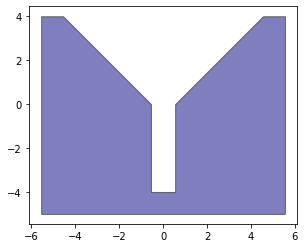

In [6]:
VertA=np.array([
[-5.55, 4],
[-5.55, -5],
[5.55, -5],
[5.55, 4 ],
[4.55, 4],
[0.55, 0],
[0.55, -4],
[-0.55, -4],
[-0.55, 0],
[-4.55, 4 ]
])

figObjA=mpatches.Polygon(VertA)
plot_poly([figObjA])

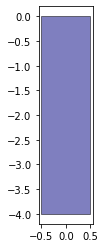

In [7]:
VertB=[
[0.5, -4],
[-0.5, -4],
[-0.5, 0],
[0.5, 0],
]

figObjB=mpatches.Polygon(VertB)
plot_poly([figObjB])

Now we can see the end result of the assembly task, a square peg inside a slot

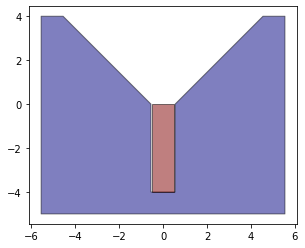

In [8]:
plot_poly([figObjA, figObjB])

Since we are doing a bunch of transformations we are using shapely instead

In [9]:
from shapely.geometry import Polygon, LineString, LinearRing
from shapely.ops import triangulate
from shapely.affinity import scale
from descartes import PolygonPatch

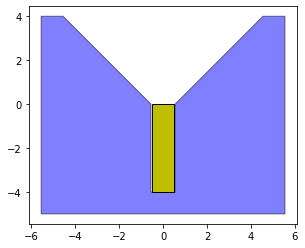

In [10]:
polygonA = Polygon(VertA)
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)
polygonB = Polygon(VertB)
patchB = PolygonPatch(polygonB, fc="y")
plot_shape([patchA, patchB])

Get all the normals of the lines

In [11]:
def prepare_object(Vert):
  #Check that object is defined as ccw
  LRObjB=LinearRing(Vert)
  if LRObjB.is_ccw is not True:
    Vert=[x for x in reversed(Vert)]
  Lines=[]
  Vectors=[]
  VectorsNorm=[]
  Edges=[]
  Verts2=[]

  # For each create an edge, a shapely line and also due to how we want iterate
  # rework our Vertices to mantain the shape. Normalize our Vectors
  for i in range(len(Vert)):
    Edge=[Vert[i-1],Vert[i]]
    Edges.append(Edge)
    Line=LineString([Vert[i-1],Vert[i]])
    Lines.append(Line)
    Verts2.append(Vert[i-1])
    Vector=np.array(Vert[i-1])-np.array(Vert[i])
    Vectors.append(Vector)
    VectorNorm = Vector/np.linalg.norm(Vector)
    VectorsNorm.append(VectorNorm)

  print("Edges")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Edges)))

  print("Vertices")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Verts2)))

  # Get the vectors of each 2D object.Super easy for 2D 
  Normals=[]
  for V in VectorsNorm:
    Norm=np.array([-V[1],V[0]])
    Normals.append(Norm)

  print("Normals")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Normals)))

  print("Vectors")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Vectors)))
  print("Vectors Normalized")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(VectorsNorm)))
  Obj={}
  Obj['Vertices']=np.asarray(Verts2)
  Obj['Edges']=Edges
  Obj['Lines']=Lines
  Obj['Vectors']=Vectors
  Obj['VectorsNorm']=VectorsNorm
  Obj['Normals']=Normals
  return Obj

In [12]:
ObjA=prepare_object(VertA)

Edges
0: [array([-4.55,  4.  ]), array([-5.55,  4.  ])]
1: [array([-5.55,  4.  ]), array([-5.55, -5.  ])]
2: [array([-5.55, -5.  ]), array([ 5.55, -5.  ])]
3: [array([ 5.55, -5.  ]), array([5.55, 4.  ])]
4: [array([5.55, 4.  ]), array([4.55, 4.  ])]
5: [array([4.55, 4.  ]), array([0.55, 0.  ])]
6: [array([0.55, 0.  ]), array([ 0.55, -4.  ])]
7: [array([ 0.55, -4.  ]), array([-0.55, -4.  ])]
8: [array([-0.55, -4.  ]), array([-0.55,  0.  ])]
9: [array([-0.55,  0.  ]), array([-4.55,  4.  ])]
Vertices
0: [-4.55  4.  ]
1: [-5.55  4.  ]
2: [-5.55 -5.  ]
3: [ 5.55 -5.  ]
4: [5.55 4.  ]
5: [4.55 4.  ]
6: [0.55 0.  ]
7: [ 0.55 -4.  ]
8: [-0.55 -4.  ]
9: [-0.55  0.  ]
Normals
0: [-0.  1.]
1: [-1.  0.]
2: [-0. -1.]
3: [1. 0.]
4: [-0.  1.]
5: [-0.70710678  0.70710678]
6: [-1.  0.]
7: [-0.  1.]
8: [1. 0.]
9: [0.70710678 0.70710678]
Vectors
0: [1. 0.]
1: [0. 9.]
2: [-11.1   0. ]
3: [ 0. -9.]
4: [1. 0.]
5: [4. 4.]
6: [0. 4.]
7: [1.1 0. ]
8: [ 0. -4.]
9: [ 4. -4.]
Vectors Normalized
0: [1. 0.]
1: [0. 

In [13]:
ObjB=prepare_object(VertB)

Edges
0: [[0.5, -4], [0.5, 0]]
1: [[0.5, 0], [-0.5, 0]]
2: [[-0.5, 0], [-0.5, -4]]
3: [[-0.5, -4], [0.5, -4]]
Vertices
0: [0.5, -4]
1: [0.5, 0]
2: [-0.5, 0]
3: [-0.5, -4]
Normals
0: [1. 0.]
1: [-0.  1.]
2: [-1.  0.]
3: [-0. -1.]
Vectors
0: [ 0. -4.]
1: [1. 0.]
2: [0. 4.]
3: [-1.  0.]
Vectors Normalized
0: [ 0. -1.]
1: [1. 0.]
2: [0. 1.]
3: [-1.  0.]


Define our edges and also our vectors and normalize them

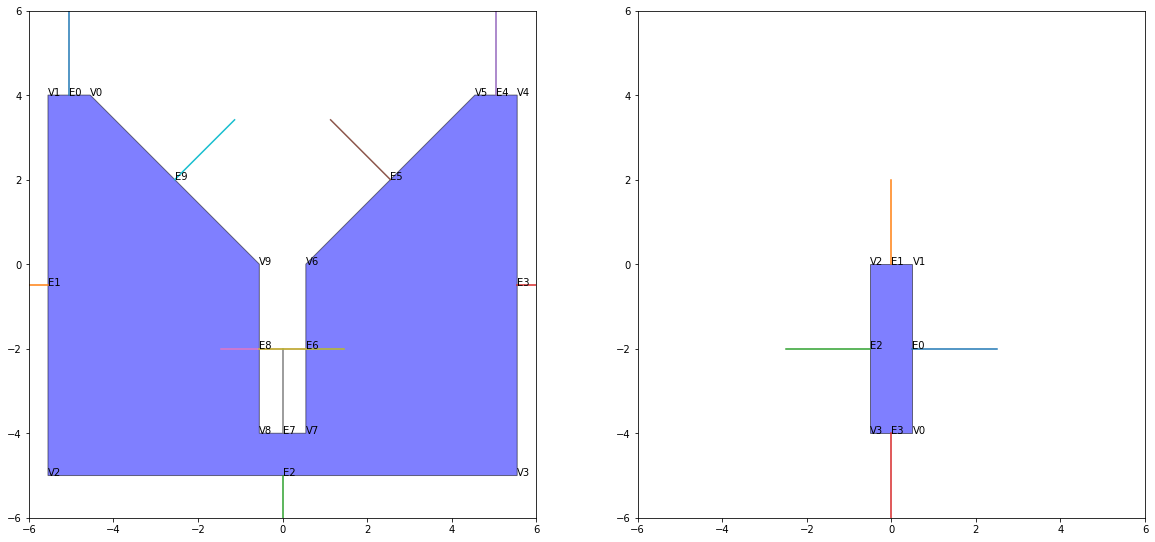

In [14]:
fig, axs= plt.subplots(1,2, figsize=(20,20))

ax=axs[0]
polygonA = Polygon(ObjA['Vertices'])
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)

for i,(e,n) in enumerate(zip(ObjA['Edges'], ObjA['Normals'])):
  mdpt=(np.add(e[0],e[1]))/2
  ax.text(mdpt[0],mdpt[1],'E{}'.format(i))
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  ax.plot(x,y)

for n, (x,y) in enumerate(ObjA['Vertices']):
  ax.text(x,y,'V{}'.format(n))

ax.add_patch(patchA)
ax.autoscale_view()
ax.set_aspect('equal','box')
ax.set_xbound(-6,6)
ax.set_ybound(-6,6)

polygonB = Polygon(ObjB['Vertices'])
patchB = PolygonPatch(polygonB, fc="b", alpha=0.5)

ax= axs[1]

for i,(e,n) in enumerate(zip(ObjB['Edges'], ObjB['Normals'])):
  mdpt=np.add(e[0],e[1])/2
  ax.text(mdpt[0],mdpt[1],'E{}'.format(i))
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  ax.plot(x,y)

for n, (x,y) in enumerate(ObjB['Vertices']):
  ax.text(x,y,'V{}'.format(n))

ax.add_patch(patchB)
ax.autoscale_view()
ax.set_aspect('equal','box')

ax.set_xbound(-6,6)
ax.set_ybound(-6,6)

plt.show()


In [15]:
def get_concave(ObjData):
    ConcaveList=[]
    for i in range(len(ObjData['Vertices'])):
        x1=np.take(ObjData['Vertices'],i, axis=0, mode='wrap')

        be1=np.take(ObjData['Normals'],i-1, axis=0, mode='wrap')
        be2=np.take(ObjData['Normals'],i, axis=0, mode='wrap')

        be1=np.append(be1,0)
        be2=np.append(be2,0)

        v=np.cross(be1,be2)

        v0=np.append(x1,0)
        v2=np.append(x1,-1)

        res=np.dot(-v, (v2- v0))

        ConcaveList.append(res)
    return ConcaveList

In [16]:
ConcaveListA=get_concave(ObjA)
ConcaveListB=get_concave(ObjB)

ObjA['Concave']=ConcaveListA
ObjB['Concave']=ConcaveListB

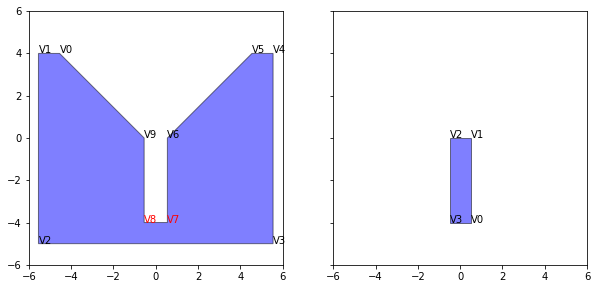

In [17]:
fig, axs= plt.subplots(1,2, sharey=True, figsize=(10,10))

ax=axs[0]
polygonA = Polygon(ObjA['Vertices'])
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)

for n, ((x,y),Clist) in enumerate(zip(ObjA['Vertices'],ConcaveListA)):
    if Clist<=0:
        ax.text(x,y,'V{}'.format(n),color='red')
    else:
        ax.text(x,y,'V{}'.format(n))



ax1=axs[1]
polygonB = Polygon(ObjB['Vertices'])
patchB = PolygonPatch(polygonB, fc="b", alpha=0.5)

for n, ((x,y),Clist) in enumerate(zip(ObjB['Vertices'],ConcaveListB)):
    if Clist<=0:
        ax1.text(x,y,'V{}'.format(n),color='red')
    else:
        ax1.text(x,y,'V{}'.format(n))

ax1.add_patch(patchB)
ax1.set_aspect('equal')

ax.add_patch(patchA)

ax.set_xbound(-6,6)
ax.set_ybound(-6,6)
ax1.set_xbound(-6,6)
ax1.set_ybound(-6,6)


ax.set_aspect('equal')

## Vertex Edge Contacts

We check for ObjA V and ObjB E.

In [18]:
def get_angle_vector(a,b):
    a1=np.arccos(a[0]/np.linalg.norm(a))
    a2=np.arccos(b[0]/np.linalg.norm(b))

    if a[1]<0:
        a1=-a1

    if b[1]<0:
        a2=-a2

    angle=a1-a2

    if angle>np.pi:
        angle=angle-2*np.pi
    elif angle<=-np.pi:
        angle=angle+2*np.pi

    return angle

def VE_feas(Angle_a, Angle_b):
    a_max=np.max([Angle_a, Angle_b])
    a_min=np.min([Angle_a, Angle_b])

    if a_max-a_min > np.pi:
        temp=a_max
        a_max=a_min+2*np.pi
        a_min=temp

    if a_max<INIT_MIN_THETA or a_min>INIT_MAX_THETA:
        feas=False
    else:
        feas=True
        
    return a_min, a_max, feas

In [19]:
ContactStates=[]
for iA, (vA, cl) in enumerate(zip(ObjA['Vertices'], ObjA['Concave'])):
    if cl>0:
        Ea=ObjA['Normals'][iA]
        Eb=ObjA['Normals'][iA-1]

        for iB, NB in enumerate(ObjB['Normals']):
            temp=-NB
            Angle_a=get_angle_vector(Ea, temp)
            Angle_b=get_angle_vector(Eb, temp)
            a_min, a_max, feas=VE_feas(Angle_a, Angle_b)
            if feas:
                print('V {}, E{}, Angle_Min {}, Angle_Max {}'.format(iA, iB,
                math.degrees(a_min), math.degrees(a_max)))
                cs={'Type':'V-E',
                    'ID':'V{}-E{}'.format(iA, iB),
                    'ElementA':vA,
                    'ElementB':ObjB['Edges'][iB],
                    'a_min':a_min,
                    'a_max':a_max}
                ContactStates.append(cs)

            

        

V 0, E3, Angle_Min -45.0, Angle_Max 0.0
V 1, E0, Angle_Min -90.0, Angle_Max 0.0
V 1, E3, Angle_Min 0.0, Angle_Max 90.0
V 2, E0, Angle_Min 0.0, Angle_Max 90.0
V 2, E1, Angle_Min -90.0, Angle_Max 0.0
V 3, E1, Angle_Min 0.0, Angle_Max 90.0
V 3, E2, Angle_Min -90.0, Angle_Max 0.0
V 4, E2, Angle_Min 0.0, Angle_Max 90.0
V 4, E3, Angle_Min -90.0, Angle_Max 0.0
V 5, E3, Angle_Min 0.0, Angle_Max 45.0
V 6, E0, Angle_Min -45.0, Angle_Max 0.0
V 9, E2, Angle_Min 0.0, Angle_Max 45.0


Now that we have the possible VE contacts based just on our rotational bounds. Now we evaluate the possible contacts based on the bounds of our robot and part penetration in those arrangements

In [20]:
print('Lower:', lb)
print('Upper:', ub)

Lower: [-1.87, 0, -0.08726646259971647]
Upper: [1.87, 24.5, 0.08726646259971647]


For example we will generate a random configuration state for the robot within the bounds defined previously.

In [21]:
conf=[]
for l,u in zip(lb,ub):
    conf.append(random.uniform(l, u))

# However for purposes of demonstration we just use the following configuration
conf=[-0.893600280993589, 2.026941294140438, -0.05591543977362778]
#conf[0]=0.1
#conf=[-1, 2, -0.05591543977362778]
print('Conf:', conf[:2], math.degrees(conf[2]))


Conf: [-0.893600280993589, 2.026941294140438] -3.203718708646811


We will need to have a way to transfer the points and objects into a different frame (defined by the configuration)

In [22]:
def transfer_pt(pt, conf):
    """
    Transfer the point from its initial frame to that defined by the configuration.
    Create a rotation matrix R and transfer the point defined by trans
    Returns a point in the given frame
    """
    trans=conf[0:2]
    angle=conf[2]
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))
    npt=np.dot(R,pt)+trans
    return npt


def transfer_vector(pt, conf):
    """
    Transfer the vector from its initial frame to that defined by the configuration.
    Create a rotation matrix R and apply
    Returns the vector in the given frame
    """
    angle = conf[2]
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))
    npt = np.dot(R, pt)
    return npt


In [23]:
#Store our original locations (In this case we just take the the last contact state obtained above)
Ao=cs['ElementB'][0]
Bo=cs['ElementB'][1]

# Transfer the points to the conf frame
A=transfer_pt(Ao, conf)
B=transfer_pt(Bo, conf)

# Get the point
P=cs['ElementA']

print('P: {} [A: {} => B: {}]'.format(P, A, B))

P: [-0.55  0.  ] [A: [-1.39281885  2.05488445] => B: [-1.61636408 -1.93886411]]


In [24]:
def mu_f(x: float) -> float:
  """
  Return the absolute value of x as lonf as it is les than 0 (-1E-3 to help with calculations)
  Returns the absolute value or zero
  """
  if x < -1E-3:
      val = abs(x)
  else:
      val = 0
  return val

def get_h1(P: npt.DTypeLike,A: npt.DTypeLike ,B: npt.DTypeLike) -> tuple[float, np.array]: 
  """
  Return the distance from the point to the line
  by taking the cross product of the vector from the pt to a 
  line segment boundary 
  Return the 
  """
  v1=P-A
  v2=B-A
  # Make them be a three vector for sanity on cross products
  v1=np.append(v1,0)
  v2=np.append(v2,0)
  # Get the length of the vector from A to B
  normalLength=np.linalg.norm(A-B)

  # Get the crossproduct and divide by our normal.
  h1=abs(np.cross(v1,v2))/normalLength
  # Return just the z component
  return h1[-1], v1, v2


def get_h2(P: npt.DTypeLike, A: npt.DTypeLike, B: npt.DTypeLike) -> tuple[float, np.array, np.array]:
  """
  Return the distance from a projected point on to the line defined by A,B
  to the boundary of the line defined by A,B. It returns 0 if the point is in the line.
  Return the mesure and the projection vector
  """
  v1=P-A
  v2=B-A

  # Make them be a three vector for sanity on cross products
  v1=np.append(v1,0)
  v2=np.append(v2,0)

  # Get the length of the vector from A to B
  normalLength=np.linalg.norm(A-B)

  #Get a vector that projects the point perpedicular to our infinate line.
  temp=np.cross(v1,v2)
  v1c=np.cross(temp,v2)/np.dot(v2,v2)
  
  #Project the point
  Pp=P+v1c[:2]

  # Obtain alpha as the distance from projected point to line segment
  if A[0]-B[0]==0:
    alpha=((Pp[1]-A[1])*normalLength)/(B[1]-A[1])
  else:
    alpha=((Pp[0]-A[0])*normalLength)/(B[0]-A[0])

  # Set it to zero if the projected is on the line segment
  h2=mu_f(alpha)+mu_f(normalLength-alpha)

  return h2, v1c, Pp




It is important to note that we are not necessarily taking the vector that results from identifying the shortest path from vertex to line segment. We are looking at the distance from the point to the line and then the distance traveling from the projected point to the line segment.

In [25]:
h1, v1, v2 = get_h1(P,A,B)
h2, v1c, Pp = get_h2(P,A,B)
result=h1+h2
print('h1: {}, h2: {}, result: {}'.format(h1, h2, result))


h1: 0.9563415457501822, h2: 0, result: 0.9563415457501822


In [67]:
def plot_vector_from_point(A: npt.DTypeLike, v:npt.DTypeLike, mscale:int, fcolor='r', ecolor='r', length_scale=1):
  """
  Create an arrow patch object from a point to another defined by the vector v
  Returns a patch object
  """
  pt1=A
  pt2=A+v[:2]*length_scale
  vArrow = mpatches.FancyArrowPatch(
      pt1, pt2, arrowstyle='-|>', mutation_scale=mscale, facecolor=fcolor, edgecolor=ecolor)
  return vArrow


In [27]:
def plot_Ve_result(ax,P,A,B,v1,v2,v1c,Pp):
  """
  Plots the representation and vectors used to determine the value related to the distance between a point and an edge
  """
  v1arrow = plot_vector_from_point(A, v1, 20, 'b', 'b')
  v2arrow = plot_vector_from_point(A, v2, 20, 'b', 'b')
  v1carrow = plot_vector_from_point(P, v1c, 20, 'r', 'r')

  ax.plot(A[0],A[1],'Pr',markersize=10) #Original transformed Boundary Point
  ax.plot(B[0],B[1],'Pr',markersize=10) #Original transformed Boundary Point
  ax.plot(P[0],P[1],'Pb',markersize=10) #Original Point
  ax.plot(Pp[0],Pp[1],'Pk',markersize=10) #Projected Point

  for lbl, coords in zip (['A','B','P','Pp'],[A, B, P, Pp]):
    ax.annotate(lbl,coords, textcoords="offset points", ha='center',xytext=(0,10), fontsize=12)

  ax.add_patch(v1arrow)
  ax.add_patch(v2arrow)
  ax.add_patch(v1carrow)
 


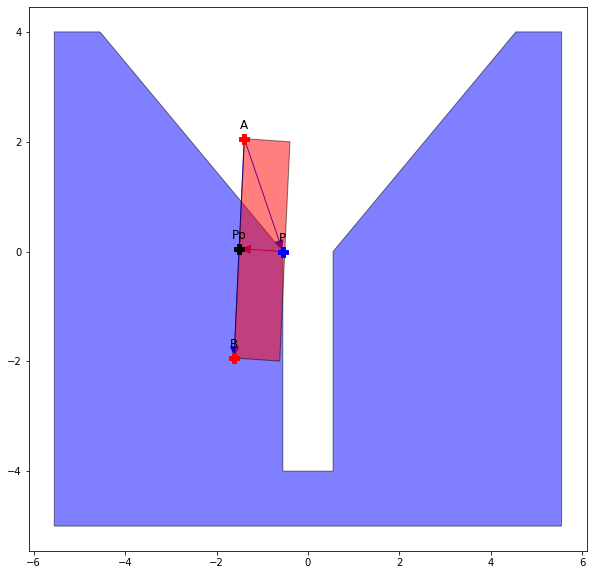

In [28]:
#fig, axs = plt.subplots(1,2,figsize=(10, 10))
fig, ax = plt.subplots(figsize = (10, 10))

plot_Ve_result(ax, P, A, B, v1, v2, v1c, Pp)
objpolyA = Polygon(ObjA['Vertices'])
objA = PolygonPatch(objpolyA, fc="b", alpha=0.5)

objpolyB=Polygon([transfer_pt(vert, conf) for vert in ObjB['Vertices']])
objB = PolygonPatch(objpolyB, fc="r", alpha=0.5)

ax.add_patch(objA)
ax.add_patch(objB)

As we can see we can determine the distance from the point to the edge, but we also have another problem. There is part interferance between the components. Because of this we need to also establish a way in which to quantify that interferance. To do so we utilize what is known as the growth distance. Which is basically a measure of how much we would have to scale the part to not result in interferance

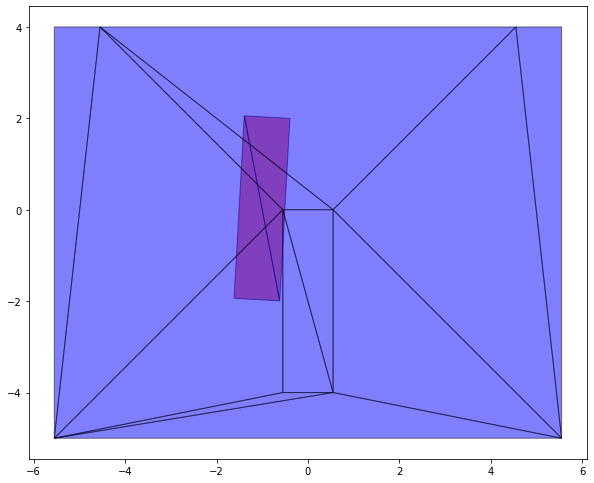

In [29]:
subObjB = triangulate(objpolyB)
subObjBpatches = [PolygonPatch(subObj, fc="r", alpha=0.5)
                  for subObj in subObjB]

subObjA = triangulate(objpolyA)
subObjApatches = [PolygonPatch(subObj, fc="b", alpha=0.5)
                  for subObj in subObjA]

fig, ax = plt.subplots(figsize=(10, 10))
for patch in subObjBpatches:
  ax.add_patch(patch)

for patch in subObjApatches:
  ax.add_patch(patch)

ax.autoscale_view()
ax.set_aspect('equal', 'box')



In [30]:
from ground.base import get_context
from sect.triangulation import Triangulation

def constrained_triangulation(Obj):
  context= get_context()
  Contour, Point = context.contour_cls, context.point_cls
  PolygonSect = context.polygon_cls

  objContour = Contour([Point(vct[0], vct[1]) for vct in Obj['Vertices']])
  sect_objcontour = PolygonSect(objContour,[])

  subObjs=Triangulation.constrained_delaunay(sect_objcontour, context=context).triangles()
  subObjsV = [[(vert.x, vert.y) for vert in subObj.vertices] for subObj in subObjs]

  return subObjsV


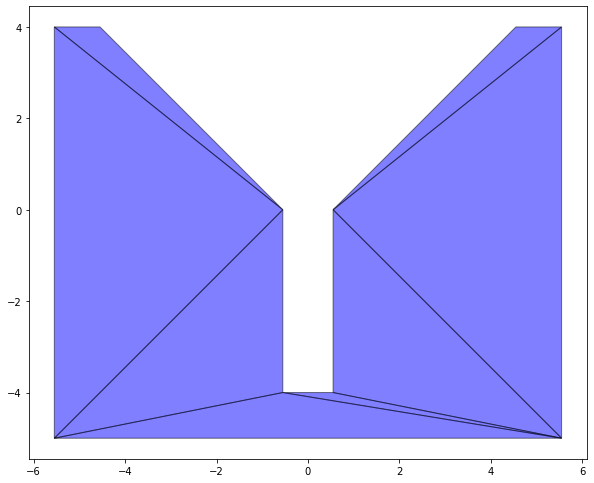

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

subObjsA=constrained_triangulation(ObjA)

for verts in subObjsA:
  objpoly = Polygon(verts)
  patch = PolygonPatch(objpoly, fc="b", alpha=0.5)
  ax.add_patch(patch)
  
ax.autoscale_view()
ax.set_aspect('equal', 'box')


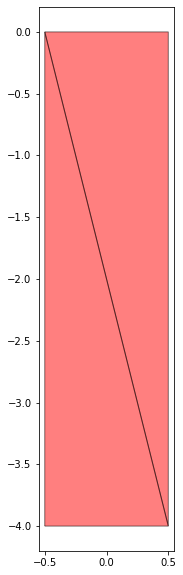

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

subObjsB = constrained_triangulation(ObjB)

for verts in subObjsB:
  objpoly = Polygon(verts)
  patch = PolygonPatch(objpoly, fc="r", alpha=0.5)
  ax.add_patch(patch)

ax.autoscale_view()
ax.set_aspect('equal', 'box')


Obviously this isn't the pretiest triangulation due to the convex points. We could probably do something less general and use the convex points to slice into smaller subobjecst but the first attempt with triangulation should work. But the super skinny elements might be an issue.

In [33]:
subObjsA=[prepare_object(subObjs) for subObjs in subObjsA]
subObjsB=[prepare_object(subObjs) for subObjs in subObjsB]

Edges
0: [(5.55, 4.0), (0.55, 0.0)]
1: [(0.55, 0.0), (5.55, -5.0)]
2: [(5.55, -5.0), (5.55, 4.0)]
Vertices
0: (5.55, 4.0)
1: (0.55, 0.0)
2: (5.55, -5.0)
Normals
0: [-0.62469505  0.78086881]
1: [-0.70710678 -0.70710678]
2: [1. 0.]
Vectors
0: [5. 4.]
1: [-5.  5.]
2: [ 0. -9.]
Vectors Normalized
0: [0.78086881 0.62469505]
1: [-0.70710678  0.70710678]
2: [ 0. -1.]
Edges
0: [(0.55, 0.0), (0.55, -4.0)]
1: [(0.55, -4.0), (5.55, -5.0)]
2: [(5.55, -5.0), (0.55, 0.0)]
Vertices
0: (0.55, 0.0)
1: (0.55, -4.0)
2: (5.55, -5.0)
Normals
0: [-1.  0.]
1: [-0.19611614 -0.98058068]
2: [0.70710678 0.70710678]
Vectors
0: [0. 4.]
1: [-5.  1.]
2: [ 5. -5.]
Vectors Normalized
0: [0. 1.]
1: [-0.98058068  0.19611614]
2: [ 0.70710678 -0.70710678]
Edges
0: [(4.55, 4.0), (0.55, 0.0)]
1: [(0.55, 0.0), (5.55, 4.0)]
2: [(5.55, 4.0), (4.55, 4.0)]
Vertices
0: (4.55, 4.0)
1: (0.55, 0.0)
2: (5.55, 4.0)
Normals
0: [-0.70710678  0.70710678]
1: [ 0.62469505 -0.78086881]
2: [-0.  1.]
Vectors
0: [4. 4.]
1: [-5. -4.]
2: [1. 0.]

In [34]:
for subObj in subObjsA:
  mdps = [(np.asarray(e[0])+np.asarray(e[1]))/2 for e in subObjsA[0]['Edges']]
  seed = Polygon(subObj['Vertices']).centroid
  subObj['Arb'] = mdps
  subObj['Seed'] = np.asarray([seed.x, seed.y])

for subObj in subObjsB:
  mdps = [(np.asarray(e[0])+np.asarray(e[1]))/2 for e in subObjsB[0]['Edges']]
  seed = Polygon(subObj['Vertices']).centroid
  subObj['Arb'] = mdps
  subObj['Seed'] = np.asarray([seed.x, seed.y])


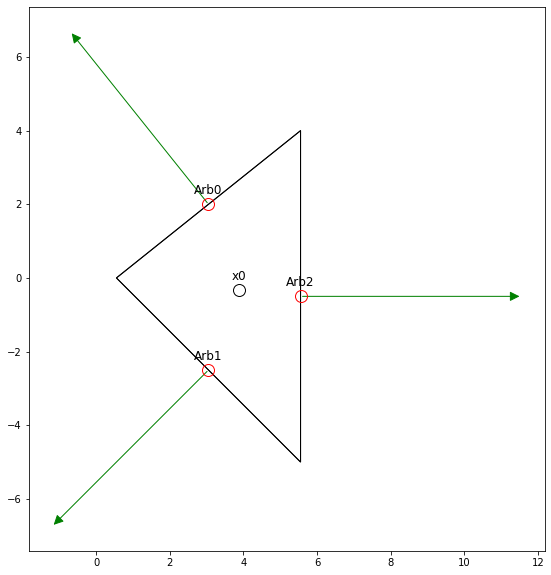

In [35]:
x0 = subObjsA[0]['Seed']
fig, ax = plt.subplots(figsize=(10, 10))
patch = PolygonPatch(Polygon(subObjsA[0]['Vertices']), fc='none')
ax.plot(x0[0], x0[1], 'ok', markersize=12, mfc='none')
ax.annotate('x0', tuple(x0), textcoords="offset points",
            ha='center', xytext=(0, 10), fontsize=12)
ax.add_patch(patch)

for n, x in enumerate(subObjsA[0]['Arb']):
  ax.plot(x[0], x[1], 'or', markersize=12, mfc='none')
  ax.annotate('Arb{}'.format(n), tuple(x), textcoords="offset points",
              ha='center', xytext=(0, 10), fontsize=12)

for pt, vc in zip(subObjsA[0]['Arb'], subObjsA[0]['Normals']):
  ax.add_patch(plot_vector_from_point(pt, vc, 20, 'g', 'g', 6))

ax.add_patch(patch)
ax.autoscale_view()
ax.set_aspect('equal', 'box')


In [36]:
gdObjA = subObjsA[0]
gdObjB = subObjsB[0]

gdNormalsA=gdObjA['Normals']
gdNormalsB=gdObjB['Normals']

gdVertA = gdObjA['Vertices']
gdVertB = gdObjB['Vertices']

gdSeedA = gdObjA['Seed']
gdSeedB = gdObjB['Seed']

gdArbA = gdObjA['Arb']
gdArbB = gdObjB['Arb']

gdSeedBwrtA=transfer_pt(gdSeedB, conf)
gdNormalsBwrtA = [transfer_vector(nrm, conf) for nrm in gdNormalsB]
gdArbBwrtA = [transfer_pt(nrm, conf) for nrm in gdArbB]
gdVertBwrtA = [transfer_pt(vert, conf) for vert in gdVertB]

#Since we triangulated we know this is three. But for generalization we make sure
FaceNumA=len(gdVertA)
FaceNumB=len(gdVertB)



In [62]:
#Initial Guesses for our GD and combine into the right shape
GD=1.0

# Number of constraints we need
ConNum=FaceNumA+FaceNumB+1

# Our Object Coefficients we only need the growth function
objCoeff=np.array([0,0,0,1])

# Right side of the inequality constraint
conB=[]
conCoeff=[]

for arb, Nrm in zip(gdArbA, gdNormalsA):
  arb_a=np.append(arb, 0)
  nrm_a=np.append(Nrm, 0)
  seed_a=np.append(gdSeedA,0)
  temp = -np.dot(arb_a-seed_a, nrm_a)
  conCoeff.append([nrm_a[0], nrm_a[1], nrm_a[2], temp])
  conB.append(np.dot(seed_a, nrm_a))

for arb, Nrm in zip(gdArbBwrtA, gdNormalsBwrtA):
  arb_b = np.append(arb, 0)
  nrm_b=np.append(Nrm, 0)
  seed_b=np.append(gdSeedBwrtA,0)
  temp=-np.dot(arb_b-seed_b, nrm_b)
  conCoeff.append([nrm_b[0],nrm_b[1],nrm_b[2], temp])
  conB.append(np.dot(seed_b, nrm_b))

conCoeff.append([0,0,0,-1])
conB.append(0)

bounds = [(None, None) for x in range(1, 4+1)]

print('obj Coeff')
print(np.matrix(objCoeff))

print('A_ub')
print(np.matrix(conCoeff))

print('B_ub')
print(np.matrix(conB).T)

print('Bounds')
print(np.matrix(bounds))


obj Coeff
[[0 0 0 1]]
A_ub
[[-0.62469505  0.78086881  0.         -2.34260643]
 [-0.70710678 -0.70710678  0.         -2.12132034]
 [ 1.          0.          0.         -1.66666667]
 [ 0.05588631  0.99843714  0.         -1.33333333]
 [-0.98218072 -0.18793889  0.         -0.32338083]
 [ 0.99843714 -0.05588631  0.         -0.33333333]
 [ 0.          0.          0.         -1.        ]]
B_ub
[[-2.6861887 ]
 [-2.51022907]
 [ 3.88333333]
 [ 0.64050011]
 [ 0.65842628]
 [-0.83881531]
 [ 0.        ]]
Bounds
[[None None]
 [None None]
 [None None]
 [None None]]


In [63]:
from scipy.optimize import linprog

res=linprog(np.array(objCoeff), A_ub=np.matrix(conCoeff), 
b_ub=np.array(conB), bounds=bounds,
options={'maxiter':100, 'presolve':False})
print(res)

temp=np.dot(res.x, objCoeff)

if temp<=1:
  gdDistance=1-temp
else:
  gdDistance=0

fscale=temp
  
print('temp: {} , distance in function: {}'.format(temp, gdDistance))


     con: array([], dtype=float64)
     fun: 1.2865754848654316
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([ 2.59758837e-09,  3.82827192e-09,  6.43287742e+00,  2.28320624e+00,
        6.94402708e-01, -2.58623833e-09,  1.28657548e+00])
  status: 0
 success: True
       x: array([-0.40525161,  0.09552516,  0.        ,  1.28657548])
temp: 1.2865754848654316 , distance in function: 0


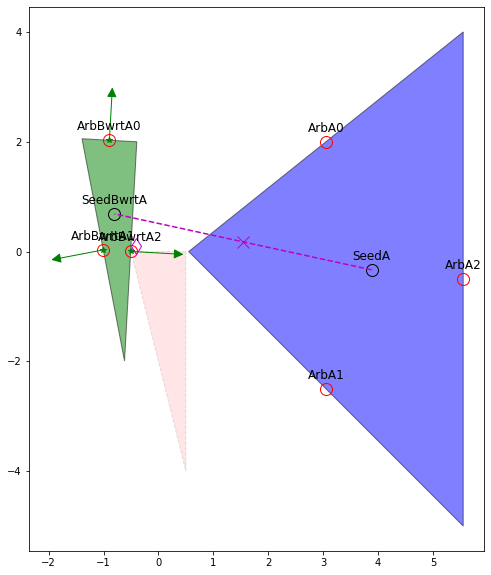

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))

polyA = PolygonPatch(Polygon(gdVertA), fc="b", alpha=0.5)

polyB = PolygonPatch(Polygon(gdVertB), fc="r", alpha=0.1, ls='--')

polyBwrtA = PolygonPatch(Polygon(gdVertBwrtA), fc="g", alpha=0.5)
ax.add_patch(polyA)
ax.add_patch(polyB)
ax.add_patch(polyBwrtA)

ax.plot(gdSeedBwrtA[0], gdSeedBwrtA[1], 'ok', markersize=12,  mfc='none')

ax.plot(gdSeedA[0], gdSeedA[1], 'ok', markersize=12, mfc='none')

ax.annotate('SeedA', tuple(gdSeedA), textcoords="offset points",
            ha='center', xytext=(0, 10), fontsize=12)

ax.annotate('SeedBwrtA', tuple(gdSeedBwrtA), textcoords="offset points",
            ha='center', xytext=(0, 10), fontsize=12)


ax.plot(np.reshape(gdArbBwrtA, (3, 2))[:, 0], np.reshape(gdArbBwrtA, (3, 2))[:, 1], '*g')

for pt, vc in zip(gdArbBwrtA, gdNormalsBwrtA):
  ax.add_patch(plot_vector_from_point(pt, vc, 20, 'g', 'g'))

for n, x in enumerate(gdArbA):
  ax.plot(x[0], x[1], 'or', markersize=12, mfc='none')
  ax.annotate('ArbA{}'.format(n), tuple(x), textcoords="offset points",
              ha='center', xytext=(0, 10), fontsize=12)

for n, x in enumerate(gdArbBwrtA):
  ax.plot(x[0], x[1], 'or', markersize=12, mfc='none')
  ax.annotate('ArbBwrtA{}'.format(n), tuple(x), textcoords="offset points",
              ha='center', xytext=(0, 10), fontsize=12)

ax.plot(res.x[0],res.x[1],'dm', mfc='none', markersize=12)
midpoint=(seed_a+seed_b)/2

x0s = np.array([seed_a, seed_b]).reshape(2, 3)[:, 0]
y0s = np.array([seed_a, seed_b]).reshape(2, 3)[:, 1]
ax.plot(midpoint[0], midpoint[1], 'xm', mfc='none', markersize=12)
ax.plot(x0s, y0s,'--m')

ax.set_aspect('equal', 'box')


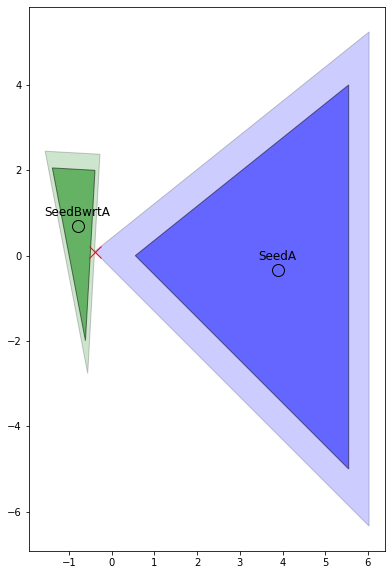

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))

shapeA = Polygon(gdVertA)
shapeAs = scale(shapeA, fscale, fscale, origin=tuple(seed_a))

polyA = PolygonPatch(shapeA, fc="b", alpha=0.5)

shapeB = Polygon(gdVertBwrtA)
shapeBs = scale(shapeB, fscale, fscale, origin=tuple(seed_b))

polyBwrtA = PolygonPatch(shapeB, fc="g", alpha=0.5)

ax.add_patch(PolygonPatch(shapeAs, fc="b", alpha=0.2))
ax.add_patch(PolygonPatch(shapeBs, fc="g", alpha=0.2))

ax.add_patch(polyA)
ax.add_patch(polyBwrtA)

ax.plot(gdSeedBwrtA[0], gdSeedBwrtA[1], 'ok', markersize=12,  mfc='none')

ax.plot(gdSeedA[0], gdSeedA[1], 'ok', markersize=12, mfc='none')

ax.annotate('SeedA', tuple(gdSeedA), textcoords="offset points",
            ha='center', xytext=(0, 10), fontsize=12)

ax.annotate('SeedBwrtA', tuple(gdSeedBwrtA), textcoords="offset points",
            ha='center', xytext=(0, 10), fontsize=12)

ax.plot(res.x[0], res.x[1], 'xr', mfc='none', markersize=12)

ax.set_aspect('equal', 'box')
